In [1]:
#from google.colab import drive
#drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

In [1]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch version: 2.5.1+cu124
CUDA available: True


In [6]:
#!mkdir -p /content/drive/My\ Drive/modules
#!mkdir -p /content/drive/My\ Drive/embeddings
#!pip uninstall torch torchvision torchaudio
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
#!pip install ftfy regex tqdm
#!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.5.1%2Bcu124-cp312-cp312-win_amd64.whl (4.1 MB)
     ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.5 GB 5.6 MB/s eta 0:07:26
     ---------------------------------------- 0.0/2.5 GB 6.4 MB/s eta 0:06:33
     ---------------------------------------- 0.0/2.5 GB 6.4 MB/s eta 0:06:31
     ---------------------------------------- 0.0/2.5 GB 6.6 MB/s eta 0:06:18
     ---------------------------------------- 0.0/2.5 GB 6.6 MB/s eta 0:06:21
     ---------------------------------------- 0.0/2.5 GB 6.3 MB/s eta 0:06:39
     ---------------------------------------- 0.0/2.5 GB 6.3 MB/s eta 0:06:39
     ---------------------------------------- 0.0/2.5 GB 5.4 MB/s eta 0:07:46
     ---------------------------------------- 0.0/2.5 GB 5.7 MB/s eta 0:07:20
     ---------------------------------------- 0.0/2.5 

  You can safely remove it manually.


# DLiP: Deepfake Classification

Group 6: Chiara Cuntz, Jesseey Moomey, Lina Oster-Daum

# 1. Introduction

* Max 300 words

* Larger context, goal, focus paper, relevance/target audience outline of the notebook

With the evolving impact and involvement of artificial intelligence in the world, the role of deepfakes on the internet becomes increasingly more apparent. In simple terms, deepfakes are images generated through machine learning algorithms, in contrast to images that are photoshopped or edited by humans. Due to the difficulty of discerning real images from deepfakes, the misuse of deepfakes raises concerns in various fields, such as politics. For this reason, many classifiers which correctly discern deepfakes from real and edited images are being developed. However, a widespread problem with such classifiers is that they perform well on their own input data but fail to generalize to new data. This generalization problem is further supported by the fact that most classifiers are only trained with one model. As Ojha et al. (2023) pointed out, this problem likely originates from feature maps created based on the input data. The feature maps end up being too specialized on one dataset, therefore, fail to generalize on other images.

The study by Ojha et al. (2023) addresses the challenge of detecting fake images generated by diverse and unseen generative models. Traditional classifiers trained on specific models, such as GANs, fail to generalize across newer models like diffusion or autoregressive models. The authors propose using a feature space from a pretrained vision-language model (CLIP) for classification without further training on real vs. fake labels. Employing nearest neighbor or linear probing in this feature space significantly improves detection accuracy, outperforming state-of-the-art methods by up to 25% on unseen models (Ojha et al., 2023).

The study by Jevnisek & Avidan (2022) proposes a novel deepfake detection approach that aggregates features across all layers of a neural network backbone. Unlike traditional methods focusing on single-layer features, the technique uses skip connections and linear regression to combine multi-scale information, improving generalization across datasets and deepfake algorithms. The model demonstrates superior accuracy and consistency in detecting both synthetic and manipulated images, achieving state-of-the-art results in cross-dataset generalization. It also enables feature importance analysis and network trimming for efficiency. This approach emphasizes robustness in real-world scenarios where detectors must handle unseen manipulations.

Based on these findings, the following implementation was proposed. … With this, our goal is to … To get a better idea of which features contribute the most in separating real from fake images, we additionally implemented lasso regression.

## Jessee Description of Our Idea: ...

# 2. Methods
Data source, data import, data pre-processing
Neural models (pre-trained networks used, new model architecture(s) + visualization, etc.)
Loss function and key performance metric (including motivation)
Fitting

# Read in and manipulate your dataset successfully
Fit a linear regression. Use only 10% of your data. You don't have to waste time waiting for models to train etc. At the moment, we just want to build the notebook and we'll worry about performance later.

In [5]:
#!pip install kagglehub
#!pip install scikit-learn
#!pip install pandas
#!pip install tensorflow
import kagglehub
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl (7.5 kB)
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 1.6/390.3 MB 7.6 MB/s eta 0:00:52
   ---------------------------------------- 3.1/390.3 MB 7.7 MB/s eta 0:00:51
    --------------------------------------- 5.2/390.3 MB 8.4 MB/s eta 0:00:46
    --------------------------------------- 7.3/390.3 MB 8.9 MB/s eta 0:00:44
    --------------------------------------- 8.7/390.3 MB 8.8 MB/s eta 0:00:44
   - -------------------------------------- 11.0/390.3 MB 8.7 MB/s eta 0:00:44
   - -------------------------------------- 12.8/390.3 MB 8.7 MB/s eta 0:00:44
   - -------------------------------------- 14.7/390.3 MB 8.7 MB/s eta 0:00:44
   - -------------------------------------- 17.0/390.3 MB 8.9 MB/s eta 0:00:42
   - -------------------------------------- 18.9/390.3 MB 9.0 MB/s eta 0:00:42
 

In [4]:
# Define a local directory to store the dataset
local_data_path = 'C:/Users/jesse/PycharmProjects/JupyterProject/deepfake_data'  # Path where the dataset will be saved
dataset_name = 'manjilkarki/deepfake-and-real-images'

# Check if the dataset is already downloaded
if not os.path.exists(local_data_path):
    print("Dataset not found locally. Downloading...")
    base_path = kagglehub.dataset_download(dataset_name)
    # Move the downloaded data to the desired local directory if needed
    os.rename(base_path, local_data_path)
    print(f"Dataset downloaded and saved to {local_data_path}")
else:
    print("Dataset found locally. Skipping download.")
    base_path = local_data_path

train_dir = os.path.join(base_path, 'Dataset', "Train")
validation_dir = os.path.join(base_path, 'Dataset', "Validation")
test_dir = os.path.join(base_path, 'Dataset', "Test")

Dataset found locally. Skipping download.


### Logistic Regression with 1% of Data

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Function to load and flatten images
def flatten_images(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        # Flatten the images (256, 256, 3) -> (256*256*3,)
        images.append(image_batch.numpy().reshape(image_batch.shape[0], -1))  # Flattening the images
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

# Flatten train, validation, and test data
X_train, y_train = flatten_images(train_data)
X_val, y_val = flatten_images(val_data)
X_test, y_test = flatten_images(test_data)

# Train a Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed

# Fit the model
logreg_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = logreg_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluate the model on the test set
y_test_pred = logreg_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Validation Accuracy: 65.82%
Test Accuracy: 71.82%


### Linear Regression with Data in Batches
This code we can delete later. For now it shows how to use the image_generator and train_model_with_batches function to load the data in batches. These functions are there twice, once for if we use a pretrained model that does not use convolution (function flattens our pictures) and one that we can use if our model uses convolution.

In [ ]:
import kagglehub
import numpy as np
import os
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Base path for the dataset (as confirmed from the verification output)
base_path = kagglehub.dataset_download('manjilkarki/deepfake-and-real-images')

# Correct directory paths
train_dir = os.path.join(base_path, 'Dataset', "Train")
validation_dir = os.path.join(base_path, 'Dataset', "Validation")
test_dir = os.path.join(base_path, 'Dataset', "Test")

# Function to create a data generator WITHOUT CONVOLUTION
def image_generator(directory, img_size=(256, 256), batch_size=32):
    """
    A generator that loads and preprocesses images in batches.
    The images are flattened for use with non-convolutional models.
    """
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=img_size,
        batch_size=batch_size
    )
    for images, labels in dataset:
        # Normalize the images and flatten
        images = images.numpy().reshape(images.shape[0], -1) / 255.0  # Normalize pixel values
        labels = labels.numpy()
        yield images, labels

# Function to create a data generator WITH CONVOLUTION
def image_generator(directory, img_size=(256, 256), batch_size=32):
    """
    A generator that loads and preprocesses images in batches for convolutional models.
    The images are not flattened, retaining their 4D shape.
    """
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=img_size,
        batch_size=batch_size
    )
    for images, labels in dataset:
        # Normalize the images (do not flatten)
        images = images / 255.0  # Normalize pixel values to [0, 1]
        yield images, labels

# Initialize directories and parameters
batch_size = 32
scaler = StandardScaler()

# Create a logistic regression model with incremental fitting
logreg_model = LogisticRegression(max_iter=5000, warm_start=True)

# Function to train a model using batches WITHOUT CONVOLUTION
def train_model_with_batches(generator, model, n_samples, batch_size):
    """
    Train a model incrementally using batches from a generator.
    """
    n_batches = n_samples // batch_size
    for i, (X_batch, y_batch) in enumerate(generator):
        if i >= n_batches:
            break
        # Normalize data
        X_batch = scaler.fit_transform(X_batch)  # Use fit_transform for the first batch
        # Incrementally train the model
        model.fit(X_batch, y_batch)

# Function to train a model using batches WITH CONVOLUTION
def train_model_with_batches(generator, model, n_samples, batch_size):
    """
    Train a Keras model incrementally using batches from a generator.
    """
    n_batches = n_samples // batch_size
    for i, (X_batch, y_batch) in enumerate(generator):
        if i >= n_batches:
            break
        # Train the model on the batch
        model.train_on_batch(X_batch, y_batch)

# Train the logistic regression model
train_gen = image_generator(train_dir, batch_size=batch_size)
train_model_with_batches(train_gen, logreg_model, n_samples=1401, batch_size=batch_size)

# Function to evaluate a model on a dataset using a generator
def evaluate_model_with_batches(generator, model):
    """
    Evaluate a model's performance using a generator.
    """
    y_true, y_pred = [], []
    for X_batch, y_batch in generator:
        X_batch = scaler.transform(X_batch)  # Apply the same scaling
        y_true.extend(y_batch)
        y_pred.extend(model.predict(X_batch))
    return accuracy_score(y_true, y_pred)

# Evaluate the logistic regression model
val_gen = image_generator(validation_dir, batch_size=batch_size)
test_gen = image_generator(test_dir, batch_size=batch_size)

val_accuracy = evaluate_model_with_batches(val_gen, logreg_model)
test_accuracy = evaluate_model_with_batches(test_gen, logreg_model)

print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.
Validation Accuracy: 50.97%
Test Accuracy: 50.43%


### Clip with batches

In [2]:
import os
import torch
from PIL import Image
import numpy as np
import tqdm
from clip import load


# Initialize the CLIP model and preprocess function
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = load("ViT-L/14", device=device)

In [9]:
model.eval()  # Ensure the model is in evaluation mode

# Generator for loading and preprocessing images
def image_generator(directory, preprocess, batch_size=32, output_path="/content/drive/My Drive/embeddings"):
    """
    A generator that preprocesses images in batches for CLIP embedding extraction,
    handling subdirectories and skipping images that already have embeddings.
    Includes a progress bar using tqdm.
    """
    all_images = []
    skipped_count = 0
    for root, _, files in os.walk(directory):
        for fname in files:
            if fname.endswith((".jpg", ".png", ".jpeg")):
                image_id = os.path.basename(fname).split('.')[0]
                embedding_file = os.path.join(output_path, os.path.basename(root), f"{image_id}.npy")
                if not os.path.exists(embedding_file):
                    all_images.append(os.path.join(root, fname))
                else:
                    skipped_count += 1
                    print(f"Skipping {image_id} - embedding already exists")

    n_samples = len(all_images)

    # Wrap the loop with tqdm for progress bar
    for i in tqdm.tqdm(range(0, n_samples, batch_size), desc="Processing images", unit="batch"):
        batch_paths = all_images[i: i + batch_size]
        images = [preprocess(Image.open(img).convert("RGB")) for img in batch_paths]
        images = torch.stack(images).to(device)
        yield images, batch_paths


# Function to extract and save embeddings
def extract_embeddings(generator, model, output_path):
    """
    Extracts CLIP embeddings for images and saves them incrementally to disk.
    """
    os.makedirs(output_path, exist_ok=True)  # Ensure output directory exists
    with torch.no_grad():  # No gradient computation for inference
        for images, paths in generator:
            embeddings = model.encode_image(images)
            embeddings /= embeddings.norm(dim=-1, keepdim=True)  # Normalize

            # Save embeddings and file paths incrementally
            for emb, path in zip(embeddings.cpu().numpy(), paths):
                image_id = os.path.basename(path).split('.')[0]
                np.save(os.path.join(output_path, f"{image_id}.npy"), emb)

# Parameters for extracting embeddings
data_dirs = {
    "train": train_dir,
    "val": validation_dir,
    "test": test_dir,
}
output_base_dir = "./embeddings"
batch_size = 200

# Process each dataset split
for split, directory in data_dirs.items():
    print(f"Processing {split} data...")
    output_dir = os.path.join(output_base_dir, split)
    generator = image_generator(directory, preprocess, batch_size=batch_size)
    extract_embeddings(generator, model, output_dir)
    print(f"Finished processing {split} data. Embeddings saved to {output_dir}")

# --- ADD THIS SECTION TO LOAD EMBEDDINGS AND LABELS ---

# Define directories where embeddings are saved
embedding_dirs = {
    "train": os.path.join(output_base_dir, "train"),
    "val": os.path.join(output_base_dir, "val"),
    "test": os.path.join(output_base_dir, "test")
}

# Function to load embeddings and labels
def load_embeddings(embedding_dir):
    embeddings = []
    labels = []  # If labels are embedded in file names or stored elsewhere
    for fname in os.listdir(embedding_dir):
        if fname.endswith(".npy"):
            # Load the embedding
            embedding = np.load(os.path.join(embedding_dir, fname))
            embeddings.append(embedding)

            # Extract label from the file name (optional)
            # Assuming labels are part of the file name, e.g., "cat_123.npy"
            label = fname.split("_")[0]  # Modify based on your naming convention
            labels.append(label)

    return np.array(embeddings), np.array(labels)

# Load train, val, and test embeddings
X_train, y_train = load_embeddings(embedding_dirs["train"])
X_val, y_val = load_embeddings(embedding_dirs["val"])
X_test, y_test = load_embeddings(embedding_dirs["test"])

# Verify shapes
print(f"Train embeddings: {X_train.shape}, Train labels: {y_train.shape}")
print(f"Validation embeddings: {X_val.shape}, Validation labels: {y_val.shape}")
print(f"Test embeddings: {X_test.shape}, Test labels: {y_test.shape}")


Processing train data...



Processing images: 100%|██████████| 701/701 [35:18<00:00,  3.02s/batch]


Finished processing train data. Embeddings saved to ./embeddings\train
Processing val data...



Processing images: 100%|██████████| 198/198 [10:21<00:00,  3.14s/batch]


Finished processing val data. Embeddings saved to ./embeddings\val
Processing test data...



Processing images: 100%|██████████| 55/55 [02:55<00:00,  3.19s/batch]


Finished processing test data. Embeddings saved to ./embeddings\test
Train embeddings: (140002, 768), Train labels: (140002,)
Validation embeddings: (39428, 768), Validation labels: (39428,)
Test embeddings: (10905, 768), Test labels: (10905,)


### Clip ViT L 14 feature extraction

In [ ]:
import torch
from PIL import Image
from clip import load, tokenize
from google.colab import files

# Step 1: Load the model with provided weights
device = "cuda" if torch.cuda.is_available() else "cpu" # Gets gpu if available
model, preprocess = load("ViT-L/14", device=device)

# Ensure the model is in evaluation mode, so it just makes features
model.eval()

# Step 2: Define datasets and corresponding directories separately
data_dirs = {
    "train": train_dir,   # Directories
    "val": validation_dir,
    "test": test_dir,
}
data_sets = {
    "train": train_data,  # Datasets
    "val": val_data,
    "test": test_data,
}

# Function to process images
def process_images(dataset, model, preprocess, device):
    """
    Processes images from the dataset, extracts embeddings using CLIP,
    and returns the embeddings.
    """
    # Initialize list to store embeddings
    embeddings = []

    for images, labels in dataset:
        # Preprocess the image batch
        processed_images = torch.stack([preprocess(Image.fromarray(img.numpy().astype(np.uint8))) for img in images])  # Convert to PIL image
        processed_images = processed_images.to(device)

        # Extract embeddings
        with torch.no_grad():
            image_features = model.encode_image(processed_images)
            embeddings.extend(image_features.cpu().numpy()) # move to CPU and convert to numpy before adding to list

    return np.array(embeddings)  # return as numpy array

# Step 3: Process images and extract embeddings
embeddings = {}
for split, dir_path in data_dirs.items():  # Iterate through directory paths
    if not os.path.exists(dir_path):
        print(f"Directory for {split} not found: {dir_path}")
        continue
    # Process images from the corresponding dataset
    embeddings[split] = process_images(data_sets[split], model, preprocess, device)

# Step 4: Save embeddings for later use

for split, results in embeddings.items():
    np.save(f"{split}_embeddings.npy", results)  # Save as .npy for each dataset split

### Define the data for fitting and testing

In [ ]:
# Step 1: Load embeddings
train_embeddings = np.load('train_embeddings.npy', allow_pickle=True)
test_embeddings = np.load('test_embeddings.npy', allow_pickle=True)
val_embeddings = np.load('val_embeddings.npy', allow_pickle=True)

# Grab the labels for y_
X_train, y_train = flatten_images(train_data)
X_val, y_val = flatten_images(val_data)
X_test, y_test = flatten_images(test_data)
# Features from Clip model for X_
X_train = train_embeddings
X_val = val_embeddings
X_test = test_embeddings


### Nearest Neighbors

For N = 1

In [11]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

# Step 2: Fit the Nearest Neighbors model
nn_model = NearestNeighbors(n_neighbors=1, metric='cosine')  # Using cosine similarity
nn_model.fit(X_train)

# Step 3: Query nearest neighbors
distances, indices = nn_model.kneighbors(X_test)

# Step 4: Retrieve predicted labels
y_pred = y_train[indices.flatten()]  # Map nearest neighbor indices to labels

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Nearest Neighbors Accuracy: {accuracy:.2f}")

# Display distances of nearest neighbors
print(f"Average Distance to Nearest Neighbor: {np.mean(distances):.4f}")

Nearest Neighbors Accuracy: 0.66
Average Distance to Nearest Neighbor: 0.1550


For N > 1

In [12]:
# Step 2: Fit the Nearest Neighbors model
nn_model = NearestNeighbors(n_neighbors=9, metric='cosine')
nn_model.fit(X_train)

# Step 3: Query nearest neighbors
distances, indices = nn_model.kneighbors(X_test)

# Step 4: Retrieve predicted labels
y_pred = np.array([np.bincount(y_train[indices[i]].astype(int)).argmax() for i in range(len(indices))])

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Nearest Neighbors Accuracy: {accuracy:.2f}")

# Display distances of nearest neighbors
print(f"Average Distance to Nearest Neighbor: {np.mean(distances):.4f}")

ValueError: invalid literal for int() with base 10: 'fake'

### Random Forest

Accuracy: 0.73

Classification Report:
              precision    recall  f1-score   support

        fake       0.68      0.87      0.76      5492
        real       0.82      0.58      0.68      5413

    accuracy                           0.73     10905
   macro avg       0.75      0.73      0.72     10905
weighted avg       0.75      0.73      0.72     10905



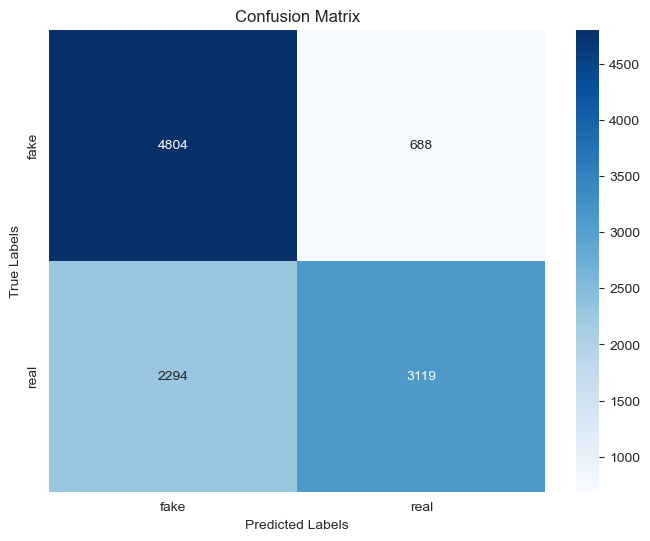

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Train the Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Step 3: Evaluate on the test set
y_pred = classifier.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### CV Lasso Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Step 2: Cross-validation for Lasso Logistic Regression
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # Inverse of regularization strength
grid_search = GridSearchCV(
    LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42),
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    verbose=1  # Show progress
)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"Best Regularization Strength (C): {grid_search.best_params_['C']}")

# Step 3: Evaluate the model on the test set
y_pred = best_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nLasso Logistic Regression Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 4: Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 5: Inspect Non-zero Coefficients (Feature Selection)
non_zero_features = np.sum(best_model.coef_ != 0, axis=1)
print("\nNon-zero Coefficients (Feature Selection):")
print(non_zero_features)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


### CV SVM

In [ ]:
from sklearn.svm import SVC

# Step 2: Define and train the SVM classifier with hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel types
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf'
}
grid_search = GridSearchCV(
    SVC(),  # SVM classifier
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    verbose=1
)
grid_search.fit(X_train, y_train)

# Step 3: Best model
best_svm = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Step 4: Test the SVM classifier on the test set
y_pred = best_svm.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nSVM Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 3. Results
Key performance metric
Comparison(s)
Model insight and robustness analysis (investigation of classification errors, what inputs fool the network, etc.)
Confidence

# 4. Conclusion / Discussion (max 300 words)
Generalizability: for new cases from which population is the model to function in accordance with the results?
Opportunities for improvement
Important takeaways for practitioners
Important takeaways for researchers

# 5. References
(min 2, max 5)

Jevnisek, A., & Avidan, S. (2022). Aggregating layers for deepfake detection. In 2022 26th International conference on pattern recognition (ICPR) (pp. 2027-2033). IEEE.

Ojha, U., Li, Y., & Lee, Y. J. (2023). Towards universal fake image detectors that generalize across generative models. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 24480-24489).

# 6. Division of Labor
Note: every group member must have worked on the model fitting with Keras, and any data pre-processing.

# Next Steps (delete in the end)

Week 1: Initial Model Development
Objective: set up the foundational model and ensure it functions with a small subset of the dataset.
Tasks:
Explore the Kaggle dataset to understand its structure, format, and size. Perform basic preprocessing, such as resizing images or normalizing pixel values.
Implement the core architecture using a combination of:
Convolutional Layers: For feature extraction.
Batch Normalization: To stabilize and accelerate training.
Pooling Layers: For down-sampling and reducing spatial dimensions.
Fully Connected Layers: To map extracted features to classifications (deepfake or real).
Test the model on a small, representative dataset to ensure functionality and debug issues.
→ Deliverables: a prototype model capable of binary classification on a reduced dataset.

Week 2: Model Expansion and Dataset Integration
Objective: scale the model to handle the full dataset and begin performance evaluation.
Tasks:
Extend the model to work with the complete dataset. This involves:
Loading and preprocessing the entire dataset.
Addressing imbalanced classes (if present) using techniques like class weights or oversampling.
Train the model on the full dataset while monitoring overfitting and performance metrics (e.g., accuracy, loss).
Add descriptive comments, modularize the code, and begin documenting the process for reproducibility.
Evaluate the model’s baseline performance and identify areas for improvement.
→ Deliverables: a functional model trained on the entire dataset with baseline performance metrics.

Week 3: Fine-Tuning, Structuring, and Finalizing
Objective: optimize the model and prepare final deliverables.
Tasks:
Fine-tune the model for improved accuracy and robustness:
Experiment with hyperparameters (learning rate, batch size, number of layers).
Introduce Dropout Layers to prevent overfitting.
Use pretrained models or transfer learning if applicable.
Test the model’s performance on unseen data to evaluate generalization.
Refine the project notebook for clarity and coherence:
Structure code into clear sections (e.g., preprocessing, model definition, training, evaluation).
Include visualizations (e.g., training/validation loss curves, confusion matrix).
Design and finalize the poster:
Highlight the problem, methodology, key findings, and learning outcomes.
→ Deliverables: a well-documented notebook, trained and fine-tuned model, and a professional poster summarizing the project.


